In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam

from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import sys,os



In [ ]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-02-21 10:00:57--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2025-02-21 10:00:57--  https://ia601606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia601606.us.archive.org (ia601606.us.archive.org)... 207.241.227.86
Connecting to ia601606.us.archive.org (ia601606.us.archive.org)|207.241.227.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M   151MB/s    in 2.8s    

2025-02-21 10:01:00 (151 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [ ]:
!unzip -qq -o Food-5K.zip

In [ ]:
!mv Food-5K/* .

In [ ]:
!ls

evaluation  Food-5K  Food-5K.zip  __MACOSX  sample_data  training  validation


In [ ]:
!mkdir data

In [ ]:
!mkdir data/train
!mkdir data/test

In [ ]:
!mkdir data/train/food
!mkdir data/train/nonfood
!mkdir data/test/food
!mkdir data/test/nonfood

In [ ]:
!mv training/0*.jpg data/train/nonfood/
!mv training/1*.jpg data/train/food/
!mv validation/0*.jpg data/test/nonfood/
!mv validation/1*.jpg data/test/food/

In [ ]:
train_path = 'data/train'
valid_path = 'data/test'

In [ ]:
IMAGE_SIZE = [200,200]

In [ ]:
image_files = glob(train_path + "/*/*jpg")
valid_image_files = glob(valid_path + "/*/*.jpg")

In [ ]:
folders = glob(train_path + "/*")

In [ ]:
K = len(folders)
K

2

In [ ]:
#load the pretrained model
ptm = PretrainedModel(input_shape=IMAGE_SIZE + [3],weights='imagenet',include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Freeze the weights
ptm.trainable = False

In [ ]:
#data Augmentation
data_augmentation = tf.keras.Sequential ([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


In [ ]:
#Build the model with functional API
i = Input(shape = (IMAGE_SIZE + [3]))
x = preprocess_input(i)
x = data_augmentation(x)
x = ptm(x)
x = Flatten()(x)
x = Dense(K,activation = "softmax")(x)

model = Model(inputs = i,outputs = x)



In [ ]:
model.compile(optimizer = 'adam',loss ="sparse_categorical_crossentropy",metrics = ["accuracy"])

In [ ]:
batch_size = 128
#Creating the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)
valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
#Optimization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
r = model.fit(train_ds,validation_data=valid_ds,epochs = 10)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 991ms/step - accuracy: 0.8071 - loss: 3.5974 - val_accuracy: 0.9620 - val_loss: 1.2156
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.9675 - loss: 0.5777 - val_accuracy: 0.9750 - val_loss: 0.5816
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 618ms/step - accuracy: 0.9861 - loss: 0.3688 - val_accuracy: 0.9770 - val_loss: 0.4367
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.9857 - loss: 0.1654 - val_accuracy: 0.9750 - val_loss: 0.4938
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 555ms/step - accuracy: 0.9905 - loss: 0.1057 - val_accuracy: 0.9740 - val_loss: 0.4846
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 641ms/step - accuracy: 0.9896 - loss: 0.1008 - val_accuracy: 0.9740 - val_loss: 0.5184
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - accuracy: 0.9949 - loss: 0.0442 - val_accuracy: 0.9750 - val_loss: 0.4289
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 552ms/step - accuracy: 0.9919 - loss: 0.0818 - val_accu

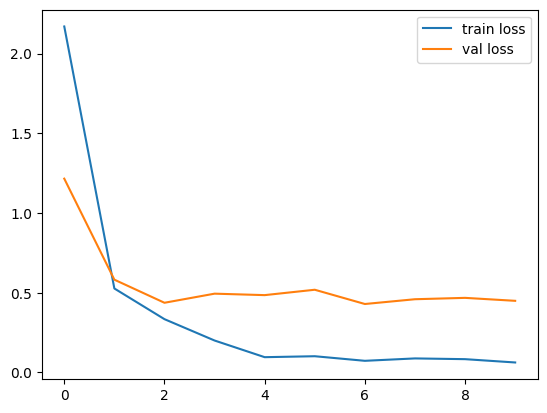

In [ ]:
plt.plot(r.history['loss'],label = "train loss")
plt.plot(r.history['val_loss'],label = "val loss")
plt.legend()
plt.show()